In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from glob import glob
import pandas as pd
import geopandas as gpd
import os
import datetime as dt
import h5py
from IPython.display import Image
from importlib import reload
import warnings 
warnings.filterwarnings("ignore")
%matplotlib inline

# Data


The data I used for this project consists of measurements over and around the Alaska Mountain Range, taken from May 1st to October 27th. The region to the North is though to be underlain by permafrost and seasonally frozen soil. In the summer, we expect to see decreases in the ground elevation as the frozen soil thaws. The data was downloaded from the National Snow and Ice Data Center (NSIDC): https://nsidc.org/data/atl06


# Pre-processing
The data is available as nested hdf5 files. In addition to the elevation and location of the measurements, these files conatain many other parameters, such as uncertainties and more detailed orbit information. We only need a small subset of this information, and we'd like to read it into a datframe to facilitate plotting and filtering. Fortunately, modules to read in and reduce this data have been written and made available as part of the ICESat-2 Hackweek program. In order to reduce the files, I will be using the modiule gda_lib from the topohack library. The full library and documentation can be found here: https://github.com/ICESAT-2HackWeek/topohack 

note: in theory you should be able to import this is one step using "from topohack.topolib import gda_lib". For some reason I couldn't get this to work, which is why it's currently done in three steps

In [4]:
cd topohack

/Users/m1bryant/Documents/Python/SIO_113_final/topohack


In [5]:
from topolib import gda_lib

In [6]:
cd ..

/Users/m1bryant/Documents/Python/SIO_113_final


I also used a couple of functions from the tutorial on hdf5 files from the 2019 ICESat-2 hackweek:https://github.com/ICESAT-2HackWeek/ICESat2_hackweek_tutorials/tree/1.0/04_HDF5AndICESat2Data_Paolo

In [7]:
def time_from_fname(fname):
    """ IS2 fname -> datatime object. """ #from ICESAT-2 hackweek tutrial 4
    t = fname.split('_')[1]
    y, m , d, h, mn, s = t[:4], t[4:6], t[6:8], t[8:10], t[10:12], t[12:14]
    time = dt.datetime(int(y), int(m), int(d), int(h), int(mn), int(s))
    return time

def RGT_from_fname(fname): #added in by me, modeled after functions from ICESAT-2 hackweek tutrial 4
    """ IS2 fname -> segment number. """
    s = fname.split('_')[2]
    return (s[0:4])

In [3]:
data_dir = 'ATL06_Healy' #REPLACE with data directory
dir_name_length = len(data_dir) #this will be useful later, so we can extract the file name without the directory
files = glob(data_dir + '/*.h5') #get list of all track files
data_dict = {'land_ice_segments': ['h_li', 'latitude', 'longitude', 'atl06_quality_summary'],\
             'ancillary data':['data_start_utc'], 'orbit_info':['rgt']} #attributes we want to extract
ATL06_tracks = [] #initialize list for reduced tracks
#adapted from example in topohacks:
for f in files:
    track_df = gda_lib.ATL06_2_gdf(f, data_dict) #read data from file into a dataframe
    fname = f[dir_name_length:-1] #get name without the directory name
    #extract rgt and date from the file name
    rgt = RGT_from_fname(fname)
    date = time_from_fname(fname)
    track_df['RGT'] = [rgt] * len(track_df)
    track_df['date'] = [date] * len(track_df)
    ATL06_tracks.append(track_df)
    
ATL06_df = gda_lib.concat_gdf(ATL06_tracks) #combine tracks into one dataframe
#get the date as an integer for plotting purposes:
date_0 = dt.date(2019,5,1).toordinal() #REPLACE with desired reference date
days = [(d.toordinal() - date_0) for d in ATL06_df['date']] #get number of days since the reference date for each data point
ATL06_df['Days Since May 1st'] = days #REPLACE 'May 1st' with your reference date

NameError: name 'glob' is not defined

In [2]:
ATL06_df.head() #preview the data

NameError: name 'ATL06_df' is not defined

I applied some spatial filtering originally, because I didn't properly subset the data when I downloaded it. I don't think we'll need this, but I'll leave it just in case.

In [10]:
#bounds of study area:
lat_min = 62.5
lat_max = 64.5
lon_min = -149
lon_max = -143
#filter data:
ATL06_points = ATL06_df.loc[((ATL06_df['latitude'] < 64.5) & (ATL06_df['latitude'] > lat_min) )& (\
                           (ATL06_df['longitude'] < lon_max) & ATL06_df['longitude'] > lon_min)]


# Plotting and Filtering
All of the functions needed are stored in the ATL06_functions module:

In [11]:
import ATL06_functions


I think this plotting function is not really necessary, as you can dot he same thing in one line line using the .ploit method on a dataframe. It does have the option to filter the data by quality, which saves you one or 2 lines of code 

In [12]:
help(ATL06_functions.plot_ATL06)

Help on function plot_ATL06 in module ATL06_functions:

plot_ATL06(data, attribute=None, filtered=False)
    Plots the provided ATL06 tracks by longitude and latitude. If an attribute is provided, the points data is colored 
    according to the specified attribute. Data can also be filtered to remove low-quality data
    Parameters
    ___________
    data: dataframe 
    ATL06 tracks to be plotted
    
    attribute(optional): string
    attribute to use for the colorbar. If no attribute is selected, all points will be plotted in black
    
    filtered: boolean
    specifies wether you want to filter out low-quality data (indicated by a quality_summary value of 1)
    
    Returns
    _________+
    none



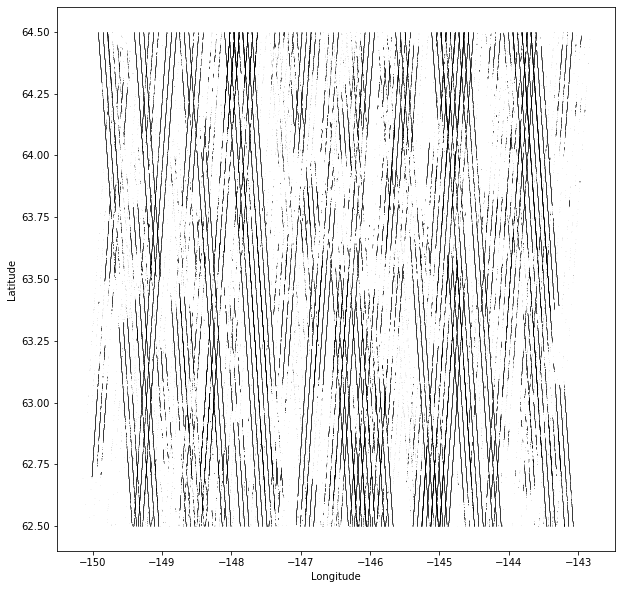

In [13]:
ATL06_functions.plot_ATL06(ATL06_points) #alternatively, ATL06_points.plot(x='longitude', y='latitude', kind='scatter', c='k', s=.000)

In [1]:
#alternativly(and this is teh more flexible way t0o do it)
ATL06_points.plot(x='longitude', y='latitude', kind='scatter', c='k', s=.0001)

NameError: name 'ATL06_points' is not defined

We can plot the tracks by elavation:

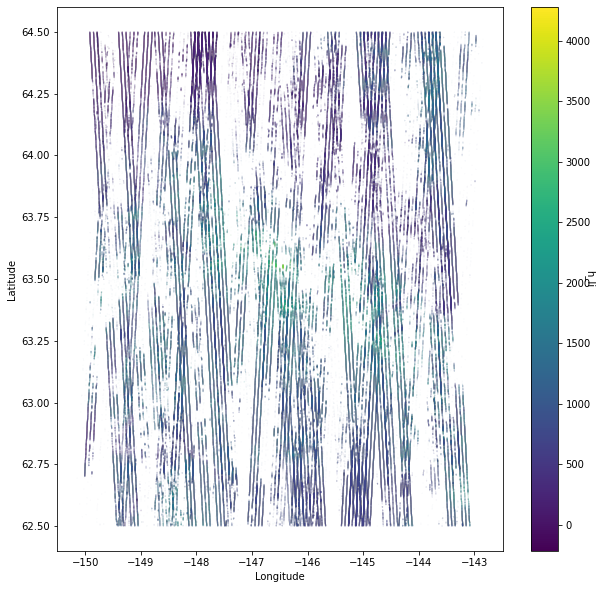

In [14]:
ATL06_functions.plot_ATL06(ATL06_points, 'h_li')

In [ ]:
ATL06_points.plot(x='longitude', y='latitude', kind='scatter', c='h_li', s=.0001)

or by time(with reference to the beginning of my study period):

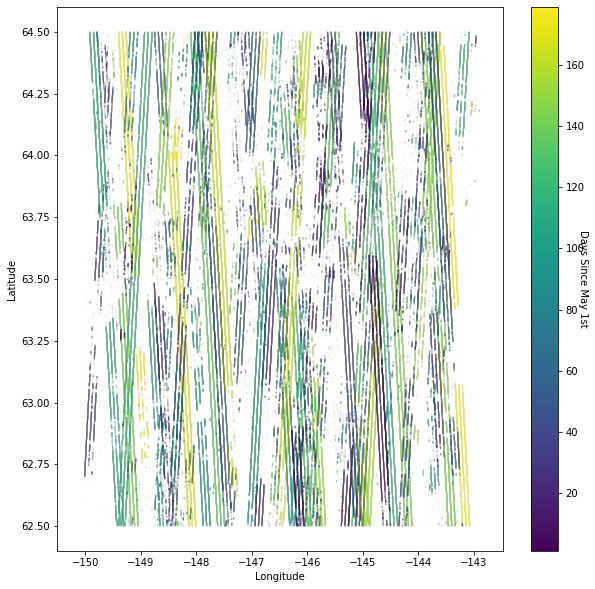

In [15]:
ATL06_functions.plot_ATL06(ATL06_points, 'Days Since May 1st')

So far, I've included all of the data, including the points flagged as low quality. We can also filter for just high-quality points:

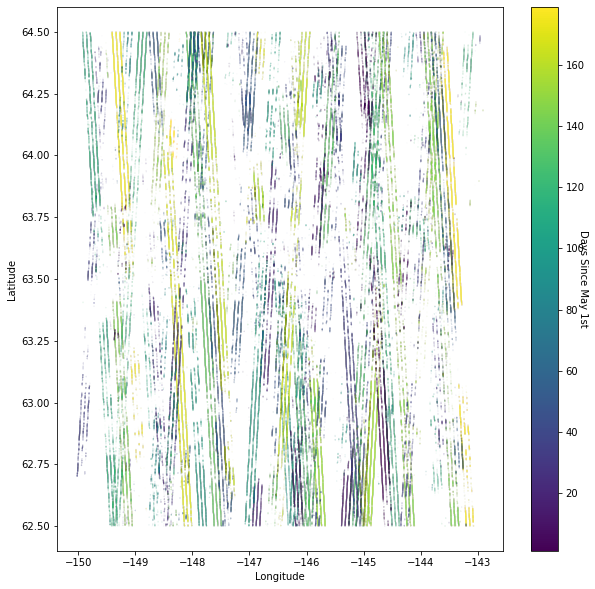

In [16]:
ATL06_functions.plot_ATL06(ATL06_points, 'Days Since May 1st', filtered = True)

Now we want to isolate a region where there are crossovers. To do this, we use the function select_crossover. This makes a plot showing the specified bounding box, and returns a dataframe filtered to that box:

In [17]:
help(ATL06_functions.select_crossover)
    

Help on function select_crossover in module ATL06_functions:

select_crossover(data, lons, lats, attribute=None, filtered=False)
    Filters the provided dataframe based on the provided bounding lon.lat values and highlights the selction on the 
    full data plot map
    Parameters:
    ___________
    data: dataframe 
    dataframe with ATL06 track data
    
    lons: list
    list of minimum and maximum longitude
    
    lats: list
    list of minimum and maximum longitudes
    
    attribute:
    see plot_ATL06
    
    filtered:
    see plot_ATL06
    
    Returns
    __________
    ATL06_filtered: dataframe
    A filtered dataframe conatining only the data in the specified lon/lat range



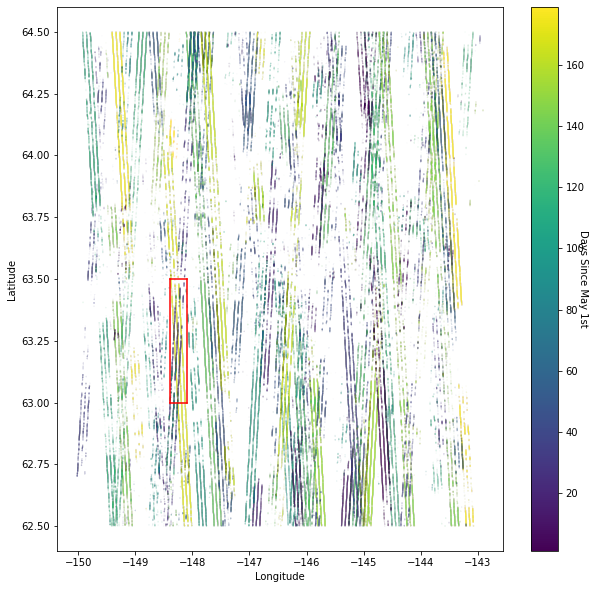

In [18]:
#REPLACE coordinates in argument with desired bounding box
ATL06_filtered = ATL06_functions.select_crossover(ATL06_points, [-148.4,-148.1], [63, 63.5], attribute = 'Days Since May 1st', filtered = True)

We can now make a 3-d plot of all of the tracks included in this, in order to see what the data looks like where there are crossovers 

In [28]:
help(ATL06_functions.plot_crossovers_3d)
    
        

Help on function plot_crossovers_3d in module ATL06_functions:

plot_crossovers_3d(ATL06_filtered, rgt_list=None)
    Makes a 3-d elevation plot of specified tracks in the provided dataframe
    
    Parameters
    __________
    ATL06_filtered: dataframe
    dataframe containing crossover tracks
    
    rgt_list: list
    list of rgt tracks to be plotted, if you only want to plot a subset of them. If no list is provided, all tracks
    will be plotted
    
    Returns
    ________
    none



<IPython.core.display.Javascript object>


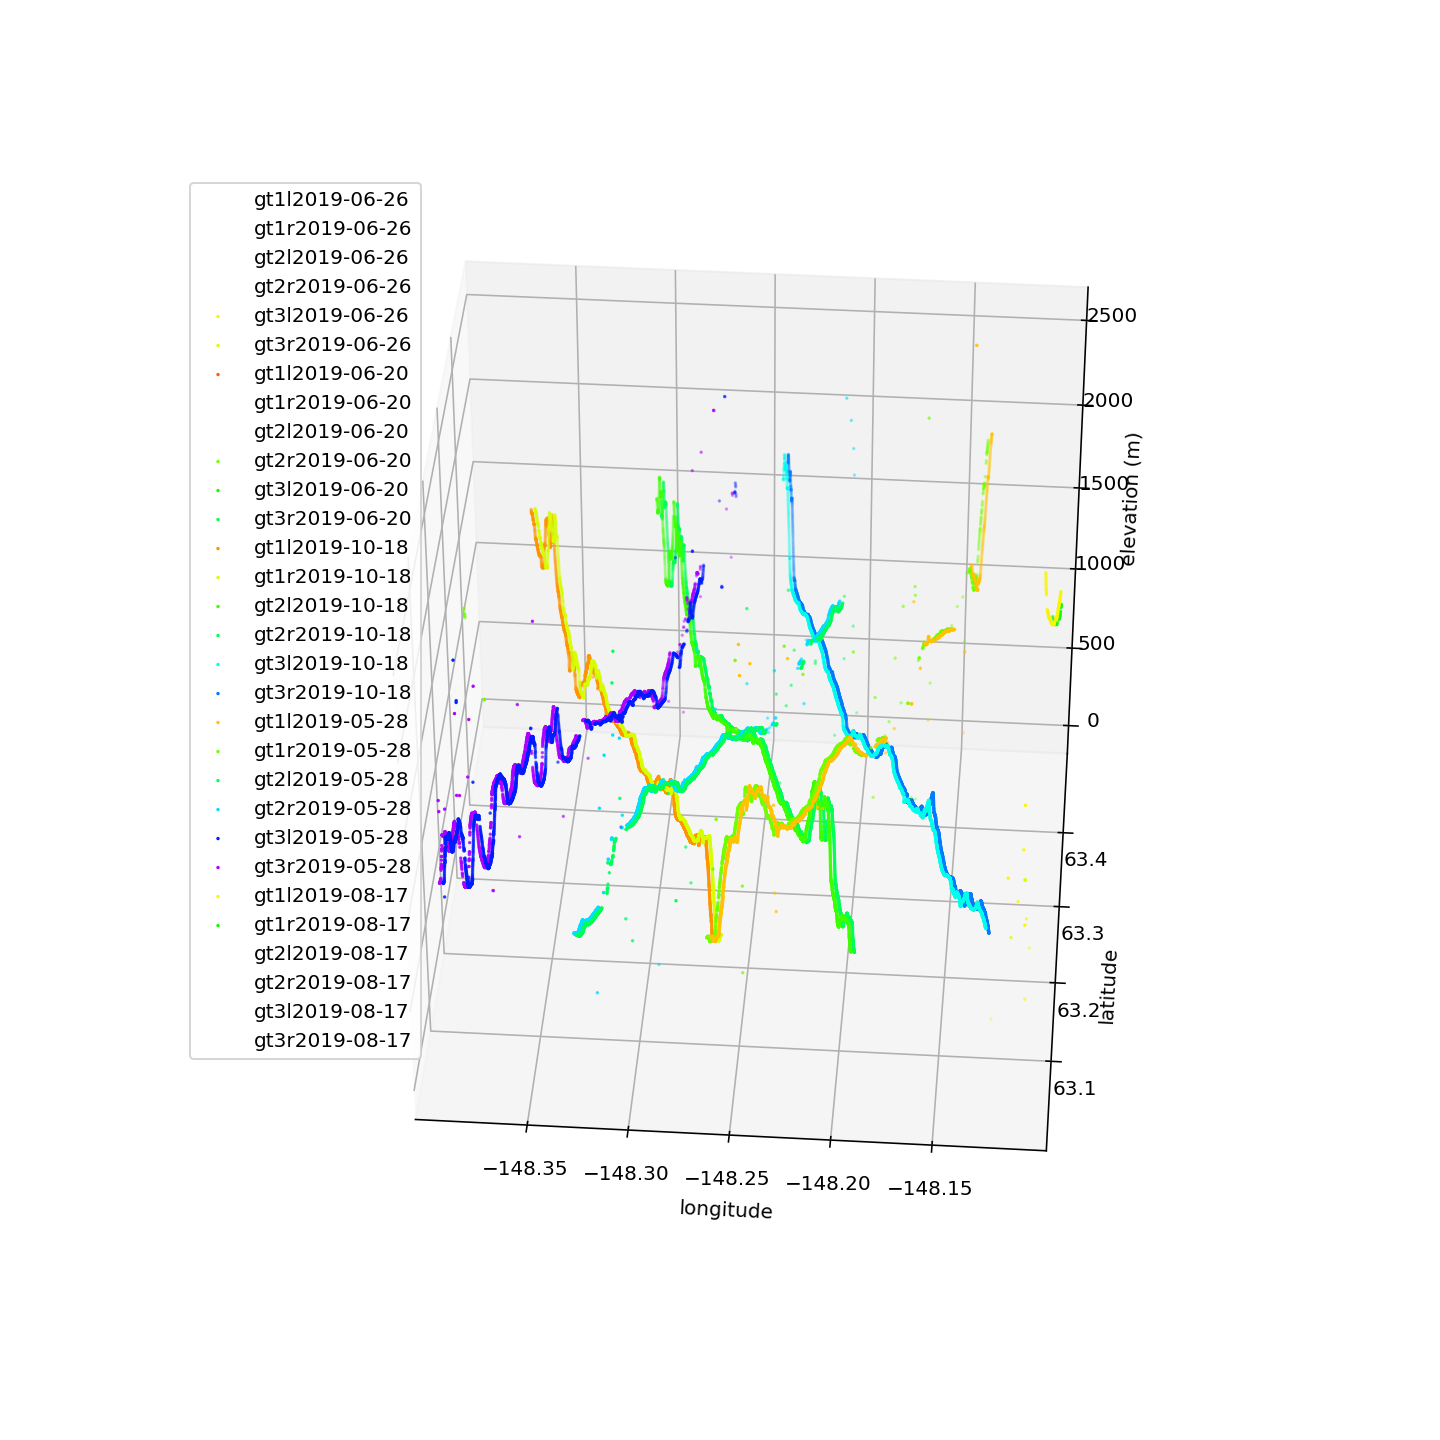

In [35]:
%matplotlib notebook
%matplotlib notebook
ATL06_functions.plot_crossovers_3d(ATL06_filtered)

We now have an interactive plot that shows us what the topography looks like at the crossover points, as well as where there is or isn't data. However, we see that the legend has more entries than visible tracks. This is because the function is currently including some tracks where there is only a handful of points in the specified range. We can use the function get_summary to get a list of which tracks are being plotted, and how many points they have. 

In [36]:
help(ATL06_functions.get_summary)

Help on function get_summary in module ATL06_functions:

get_summary(ATL06_filtered)
    provides a summary of a given subset of the data: what tracks are present, what dates they were measured, and 
    how many individula data point are present fior each one. The spatial extent is also included for reference.
    
    Parameters
    __________
    ATL06_filtered: dataframe to be summarized
    
    Returns:
    _________
    summary: dataframe
    a dataframe that list all RGTs in the dataset, along with their measurement date, number of measurements, and 
    the spatial extent covered.



In [39]:
summary = ATL06_functions.get_summary(ATL06_filtered)
display(summary)

[[-148.39922249752544, -148.10003576274886], [63.00001012221029, 63.499997393376795]]


,RGT,Date,Number of points,Extent
0,1356,2019-06-26 01:28:11,28,"[[-148.39922249752544, -148.10003576274886], [..."
1,1272,2019-06-20 13:17:18,116,"[[-148.39922249752544, -148.10003576274886], [..."
2,0327,2019-10-18 07:33:14,16782,"[[-148.39922249752544, -148.10003576274886], [..."
3,0914,2019-05-28 02:52:11,15669,"[[-148.39922249752544, -148.10003576274886], [..."
4,0769,2019-08-17 10:29:23,287,"[[-148.39922249752544, -148.10003576274886], [..."


From this, we can see most of the data is coming from two tracks. We can re-do our plot with just these two tracks:

<IPython.core.display.Javascript object>


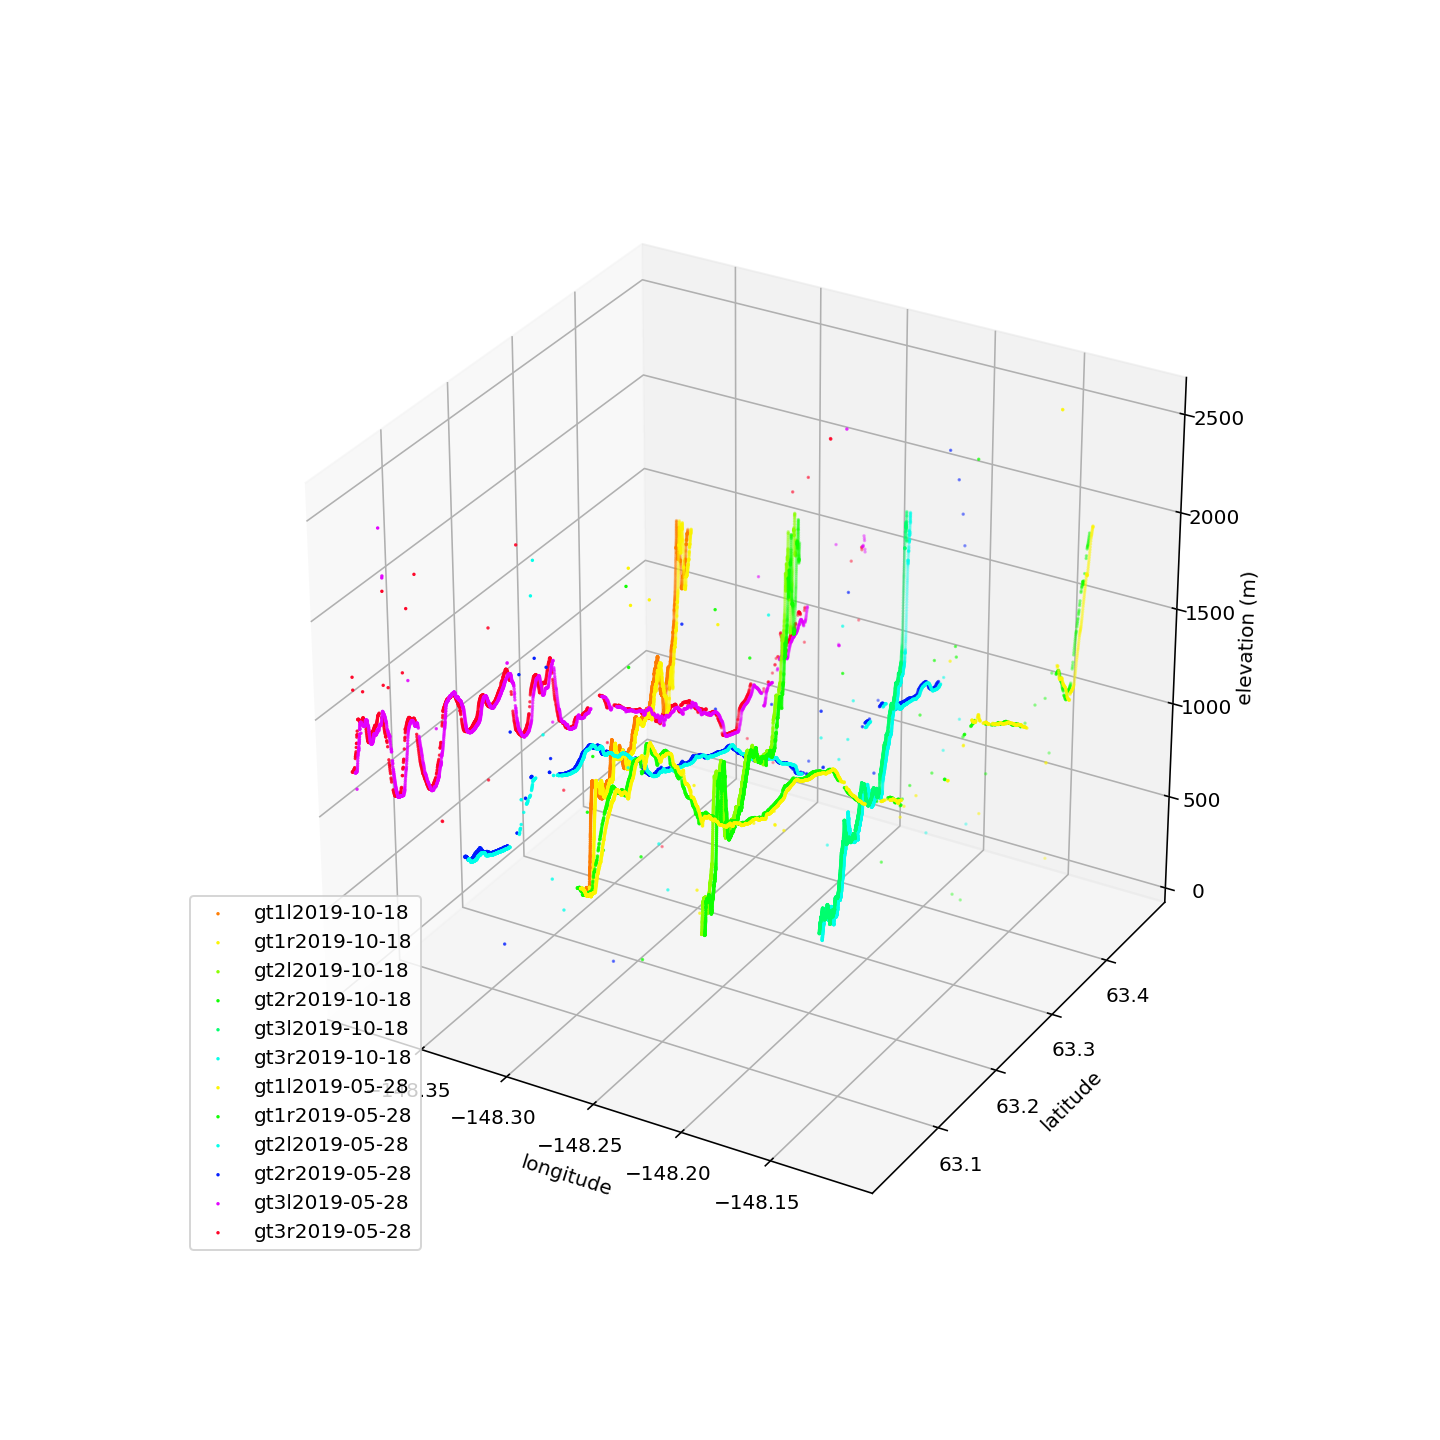

In [41]:
ATL06_functions.plot_crossovers_3d(ATL06_filtered, rgt_list = ['0327', '0914']) #REPLACE with desired rgts